# Mapping County Max Temperatures
The purpose of this notebook is to learn how to map data onto a shapefile. The analysis and EDA is kept to a bare minimum for this reason.
### Import necessary packages

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import math
import descartes
import geoplot
import plotly.figure_factory as ff

## Load in Shape file with Geopandas

In [2]:
map_df = gpd.read_file('tl_2017_us_county/tl_2017_us_county.shp')

In [3]:
map_df.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-96.91060 40.95841, -96.91060 40.958..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


In [4]:
map_df_CONUS = map_df[~map_df['STATEFP'].isin(['02', '66', '15', '72', '78', '69', '60'])]

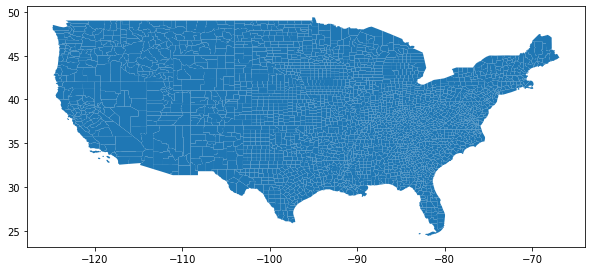

In [12]:
map_df_CONUS.plot(figsize = (10,10))
fig = plt.gcf()
plt.show()
fig.savefig('shapefile_initial_plot.png')

## Load in County Max Temp data and convert to CSV

Take only most recent year

In [14]:
length = [2, 3, 2, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

pd.read_fwf("climdiv-tmaxcy-v1.0.0-20191104", widths=length).to_csv("climdiv-tmaxcy.csv")

In [15]:
max_temp_df = pd.read_csv('climdiv-tmaxcy.csv', header = None)

In [16]:
max_temp_df.columns = ['Unnamed: 0', 'State_Code', 'Division_Number',
                       'Element_Code', 'Year', 'Jan', 'Feb', 'Mar', 'Apr',
                       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [17]:
max_temp_df.drop(columns = ['Unnamed: 0'], inplace = True)

In [18]:
max_temp_2018_df = max_temp_df.loc[max_temp_df['Year'] == 2018]

## Create FIPS Columns in each df

In [19]:
map_df_CONUS['FIPS'] = map_df_CONUS.STATEFP + map_df_CONUS.COUNTYFP

In [20]:
max_temp_2018_df.State_Code = max_temp_2018_df.State_Code.apply(lambda x : "{0:0=2d}".format(x))

In [21]:
max_temp_2018_df.Division_Number = max_temp_2018_df.Division_Number.apply(lambda x : "{0:0=3d}".format(x))

In [22]:
max_temp_2018_df['FIPS'] = max_temp_2018_df.State_Code + max_temp_2018_df.Division_Number

## Merge together map and data dataframes

In [23]:
merged_df = map_df_CONUS.merge(max_temp_2018_df, left_on = 'FIPS', right_on = 'FIPS', how = 'left')

In [24]:
merged_df

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,56.1,64.7,79.6,84.3,84.0,83.2,82.5,70.4,55.0,50.2
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,54.0,59.3,65.5,70.6,77.2,76.0,73.0,65.8,57.8,51.4
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,57.6,69.6,82.5,88.5,88.5,87.7,85.7,73.3,57.4,52.8
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,61.5,71.0,81.8,88.6,86.8,89.0,86.2,77.6,65.6,59.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,...,46.6,54.3,80.7,84.6,85.1,85.2,77.6,60.6,39.2,38.5
3104,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3105,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3106,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Mapping

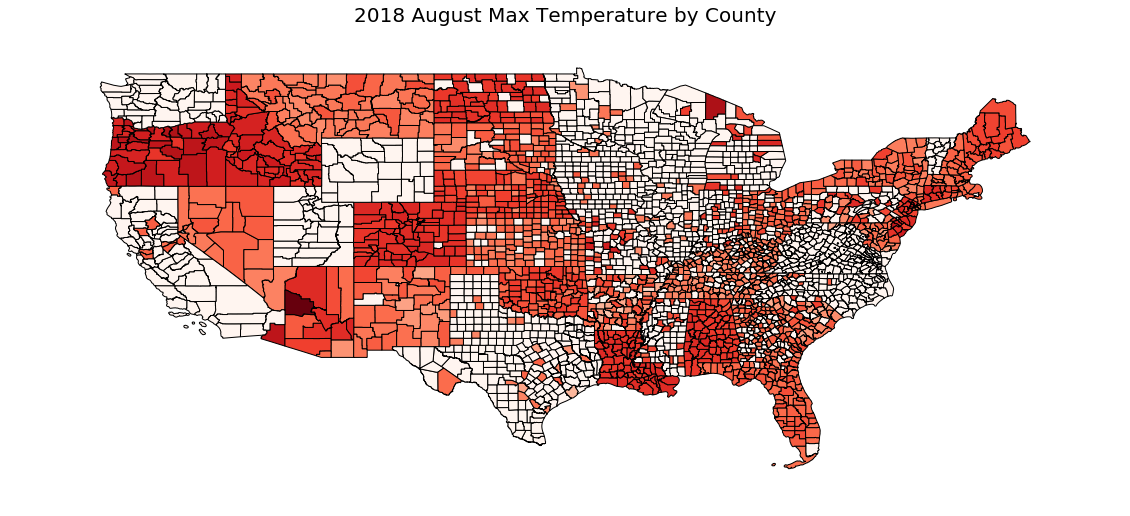

In [25]:
geoplot.choropleth(
    merged_df, hue = merged_df.Aug,
    cmap='Reds', figsize=(20, 20))
fig = plt.gcf()
plt.title('2018 August Max Temperature by County', fontsize = 20)
plt.show()
fig.savefig('Aug_2018_Max_Temp_County.png')

### Conclusion
You can see that data for many counties is missing, however the data was successfully mapped onto the shapefile.